# EXPERIMENT REPORT - 4

#### IMPORTING PACKAGES

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pickle

#### DATA CLEANING, IMPUTATION AND FEATURE ENGINEERING

In [2]:
df_train = pd.read_csv('../data/interim/cleaned_train_data_draft_pred.csv')
df_test = pd.read_csv('../data/interim/cleaned_test_data_draft_pred.csv')

In [3]:
df_train.select_dtypes(include=['float']).isna().sum()

Min_per                    0
Ortg                       0
usg                        0
eFG                        0
TS_per                     0
ORB_per                    0
DRB_per                    0
AST_per                    0
TO_per                     0
FT_per                     0
twoP_per                   0
TP_per                     0
blk_per                    0
stl_per                    0
ftr                        0
ht                       363
num                        0
porpag                     0
adjoe                      0
pfr                        0
Rec_Rank               39055
ast_tov                 4190
rimmade                 6081
rimmade_rimmiss         6081
midmade                 6081
midmade_midmiss         6081
rim_ratio               9464
mid_ratio               9688
dunksmade               6081
dunksmiss_dunksmade     6081
dunks_ratio            30793
pick                   54705
drtg                      44
adrtg                     44
dporpag       

Creating new features from the dataset and imputing missing values with 0 

In [4]:
df_train['dunk_missed'] = df_train['dunksmiss_dunksmade'] - df_train['dunksmade']
df_train['rim_miss'] = df_train['rimmade_rimmiss'] - df_train['rimmade']
df_train['mid_miss'] = df_train['midmade_midmiss'] - df_train['midmade']
df_test['dunk_missed'] = df_test['dunksmiss_dunksmade'] - df_test['dunksmade']
df_test['rim_miss'] = df_test['rimmade_rimmiss'] - df_test['rimmade']
df_test['mid_miss'] = df_test['midmade_midmiss'] - df_test['midmade']

In [5]:
na_with_zero = ['dunksmade', 'dunksmiss_dunksmade', 'dunks_ratio', 'dunk_missed',
         'rim_miss', 'mid_miss','rimmade_rimmiss', 'midmade_midmiss', 'rimmade',
         'midmade', 'rim_ratio', 'mid_ratio','ast_tov', 'Rec_Rank' ]
for col in na_with_zero:
    df_train[col] = df_train[col].fillna(0)
    df_test[col] = df_test[col].fillna(0)

'Pick' column has high missing values, so it is masked into 1 if we have values  otherwise 0

In [6]:
high_missing_columns = ['pick']

for col in high_missing_columns:
    df_train[col] = np.where(df_train[col].isna(),0,1)
    df_test[col] = np.where(df_test[col].isna(),0,1)


All the missing values of remaining numerical columns are imputed with mean values

In [7]:
[df_test[val].fillna(df_train[val].mean(),inplace=True) for val in df_test.columns[df_test.isnull().any(axis=0)]]   
[df_train[val].fillna(df_train[val].mean(),inplace=True) for val in df_train.columns[df_train.isnull().any(axis=0)]]    

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### FEATURE TRANSFORMATION

Compared to last experiment, One hot encoding features didn't perform well. Therefore, converting to label encoding for this experiment

In [8]:
from src.data.encoders import perform_label_encoding, perform_one_hot_encoding

In [9]:
to_encode = ['conf', 'yr']
train_df_one_enc, test_df_one_enc = perform_label_encoding(df_train, df_test, to_encode)

In [10]:
train_df_one_enc = train_df_one_enc.drop('team', axis=1)
test_df_one_enc = test_df_one_enc.drop('team', axis=1)

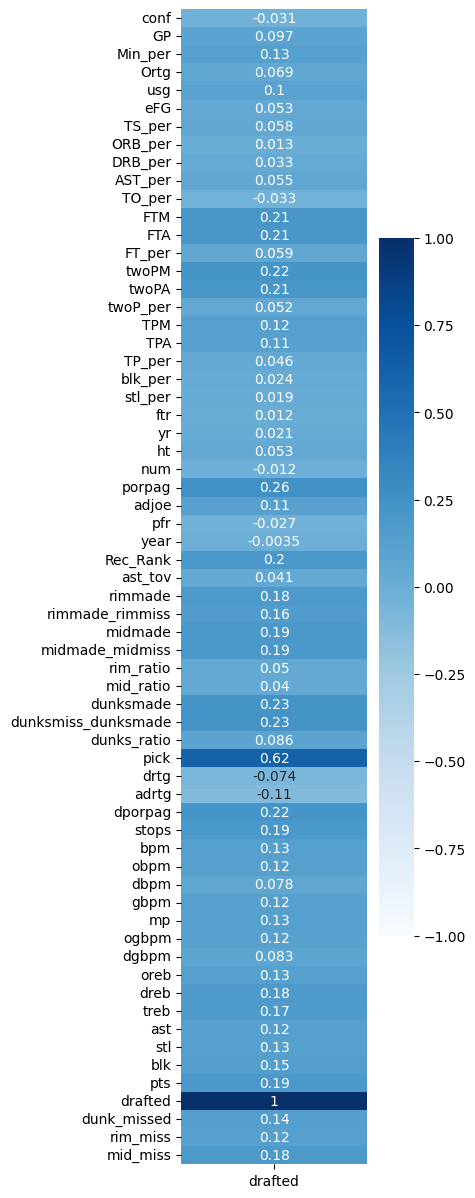

In [11]:
corr = train_df_one_enc.drop('player_id',axis=1).corr()
plt.figure(figsize=(3, 15))
heatmap = sns.heatmap(corr[['drafted']], vmin=-1, vmax=1, cmap='Blues', annot=True)

#### REMOVING MULTICOLLINEARITY
Features that were highly correlated with each other and had correlation of 95% were removed as they aid in reducing the model complexity. 

In [12]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [13]:
to_drop

['FTA',
 'twoPA',
 'TPA',
 'adjoe',
 'rimmade_rimmiss',
 'midmade_midmiss',
 'dunksmiss_dunksmade',
 'stops',
 'mp',
 'treb',
 'rim_miss',
 'mid_miss']

Storing the file for model generation

In [14]:
train_df_one_enc.to_csv('../data/processed/train_data_labelenc_cleaned.csv', index=False)
test_df_one_enc.to_csv('../data/processed/test_data_labelenc_cleaned.csv', index=False)

#### MODEL GENERATION

In [15]:
X_train = train_df_one_enc.drop(to_drop, axis=1)
X_train = X_train.drop(['player_id', 'drafted'], axis=1)
y_train = train_df_one_enc[['drafted']]

In [54]:
%load_ext autoreload
%autoreload 2
from src.models.train_model import perform_model_train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
perform_model_train(model, X_train, y_train, split_size=10, save_model=True,save_name='linear_discriminant_analysis')

/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/

------------------------------------------------------------
TRAIN SCORES for LinearDiscriminantAnalysis()
------------------------------------------------------------
Precision Score: 0.3867468354793552 +- 0.003167004446921061
Recall Score: 1.0 +- 0.0
F1 Score: 0.5577689088175293 +- 0.003298511152141811
AUC score: 0.9972694556201442 +- 6.806616450012088e-05
------------------------------------------------------------
TEST SCORES for LinearDiscriminantAnalysis()
------------------------------------------------------------
Precision Score: 0.3883206329536148 +- 0.03000493181489871
Recall Score: 1.0 +- 0.0
F1 Score: 0.5588167656062346 +- 0.030537969259027985
AUC score: 0.9972318316748654 +- 0.000755493420105078
SAVED MODEL


In [28]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
perform_model_train(model, X_train, y_train, split_size=10, save_model=True,save_name='gaussian')

/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/

------------------------------------------------------------
TRAIN SCORES for GaussianNB()
------------------------------------------------------------
Precision Score: 0.4095635182936245 +- 0.002761820388987839
Recall Score: 0.9944034947552899 +- 0.0013977761038103593
F1 Score: 0.5801657168407938 +- 0.0026052629250934932
AUC score: 0.9941876734917617 +- 8.280101531325234e-05
------------------------------------------------------------
TEST SCORES for GaussianNB()
------------------------------------------------------------
Precision Score: 0.412025500496371 +- 0.03201656836253802
Recall Score: 0.9944444444444445 +- 0.012499047365010252
F1 Score: 0.581795833150871 +- 0.029369736544112558
AUC score: 0.9941770503566876 +- 0.0007993996960441515
SAVED MODEL


In [29]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')
perform_model_train(model, X_train, y_train, split_size=10, save_model=True,save_name='lr')

/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/

------------------------------------------------------------
TRAIN SCORES for LogisticRegression(class_weight='balanced')
------------------------------------------------------------
Precision Score: 0.13949030946548532 +- 0.00565955719655406
Recall Score: 0.9709792702937209 +- 0.002576287148958294
F1 Score: 0.24390028105392864 +- 0.008630123955506658
AUC score: 0.987600686521924 +- 0.0006836003650853512
------------------------------------------------------------
TEST SCORES for LogisticRegression(class_weight='balanced')
------------------------------------------------------------
Precision Score: 0.13797220793070114 +- 0.006845336685255884
Recall Score: 0.9571977638015374 +- 0.02312555758563276
F1 Score: 0.241099186107589 +- 0.01034373783068452
AUC score: 0.9869421709389561 +- 0.0024345370275144413
SAVED MODEL


In [51]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
perform_model_train(model, X_train, y_train, split_size=10, save_model=True,save_name='ada')

/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/

------------------------------------------------------------
TRAIN SCORES for AdaBoostClassifier()
------------------------------------------------------------
Precision Score: 0.8436168954139982 +- 0.006753802933392436
Recall Score: 0.7960164256934958 +- 0.013712570040208007
F1 Score: 0.8190664900449274 +- 0.008337720514747037
AUC score: 0.999202098672578 +- 5.268674542889826e-05
------------------------------------------------------------
TEST SCORES for AdaBoostClassifier()
------------------------------------------------------------
Precision Score: 0.7693663045531552 +- 0.06877198768172482
Recall Score: 0.6865828092243186 +- 0.04478913210411916
F1 Score: 0.7233455322712902 +- 0.035226991863077414
AUC score: 0.9968597348322159 +- 0.002468488559881609
SAVED MODEL


In [54]:
from xgboost import XGBClassifier
model = XGBClassifier()
perform_model_train(model, X_train, y_train, split_size=5, save_model=True, save_name="xgb_label")

/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/l

------------------------------------------------------------
TRAIN SCORES for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
------------------------------------------------------------
Precision Score: 1.0 +- 0.0
Recall Score: 1.0 +- 0.0
F1 Score: 1.0 +- 0.0
AUC score: 1.0 +- 0.0
-------------

In [58]:
import lightgbm as lgb
model = lgb.LGBMClassifier()
perform_model_train(model, X_train, y_train, split_size=10, save_model=True, save_name="lgb")

/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


------------------------------------------------------------
TRAIN SCORES for LGBMClassifier()
------------------------------------------------------------
Precision Score: 1.0 +- 0.0
Recall Score: 1.0 +- 0.0
F1 Score: 1.0 +- 0.0
AUC score: 1.0 +- 0.0
------------------------------------------------------------
TEST SCORES for LGBMClassifier()
------------------------------------------------------------
Precision Score: 0.7219190163925119 +- 0.09161544624982873
Recall Score: 0.6976939203354299 +- 0.0657062520052676
F1 Score: 0.7057714033322543 +- 0.05638682534423421
AUC score: 0.9977749730329812 +- 0.0006520500646422653
[LightGBM] [Info] Number of positive: 536, number of negative: 55555
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10347
[LightGBM] [Info] Number of data points in the train set: 56091, number of used features: 51
[LightGBM]

#### HYPERPARAMETER TUNING

In [17]:
# !pip install xgbtune
from xgbtune import tune_xgb_model
params = {'eval_metric': 'auc'}
params, round_count = tune_xgb_model(params, X_train, y_train)

tuning pass 0...
computing best round...
best round: 3
tuning max_depth and min_child_weight ...
best loss: 0.9989
best max_depth: 5
best min_child_weight: 1
tuning gamma ...
best loss: 0.9989
best gamma: 0.0
re-computing best round...
best round: 3
tuning subsample and colsample_bytree ...
best loss: 0.9083
best subsample: 1.0
best colsample_bytree: 0.0
fine tuning subsample and colsample_bytree ...
best loss: 0.9083
best subsample: 1.0
best colsample_bytree: 0.0
tuning alpha and lambda ...
best loss: 0.8602
best alpha: 0.5
best lambda: 5
tuning seed ...
best loss: 0.8348
best seed: 42
{'eval_metric': 'auc', 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.0, 'subsample': 1.0, 'colsample_bytree': 0.0, 'alpha': 0.5, 'lambda': 5, 'seed': 42}
tuning pass 1...
computing best round...
best round: 46
tuning max_depth and min_child_weight ...
best loss: 0.9907
best max_depth: 5
best min_child_weight: 1
tuning gamma ...
best loss: 0.9816
best gamma: 0.3
re-computing best round...
best round:

In [22]:
from xgboost import XGBClassifier
model = XGBClassifier(**params)
perform_model_train(model, X_train, y_train, split_size=10, save_model=True, save_name="xgb_tuned")

/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/l

------------------------------------------------------------
TRAIN SCORES for XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1.1, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)
------------------------------------------------------------
Precision Score: 0.9372728211678142 +- 0.00787667430694048
Recall Score: 0.5723422076750598 +- 0.009828193033382076
F1 Score: 0.7106407427599023

#### LOADING THE MODEL AND PREDICTING 

In [60]:
from src.models.predict_model import model_prediction

Selecting required features for prediction

In [61]:
test_df_one_enc = test_df_one_enc[X_train.columns]

In [62]:
model_prediction(test_df_one_enc, df_test, model_name='model_linear_discriminant_analysis', csv_file_name='lda_final_csv', save_file=True)

                                 player_id       drafted
0     cf302b4d-84f7-4124-a25d-a75eed31978b  1.367879e-17
1     f91837cd-4f49-4b70-963d-aeb82c6ce3da  1.918641e-18
2     53ec2a29-1e7d-4c6d-86d7-d60d02af8916  6.080636e-19
3     32402798-471c-4a54-8cb4-29cd95199014  1.211190e-18
4     73b960f9-27b8-4431-9d23-a760e9bbc360  1.839657e-19
...                                    ...           ...
4965  a25ee55f-02a3-4f8e-8194-a5f427e14e7c  2.474332e-19
4966  d0d9f45e-7b01-44b3-8d40-514ec338611d  2.073813e-17
4967  f8df22c4-1602-4fab-896d-8820951aae2f  1.294483e-18
4968  b791c69a-f769-4163-afda-051a6fd20a9d  1.365507e-18
4969  18b51f5d-4746-4121-88fd-c8d0a1399130  5.109534e-20

[4970 rows x 2 columns]
csv saved


#### FOR ROC CURVE 

In [31]:
X_train_roc, X_val, y_train_roc, y_val = train_test_split(X_train,y_train, shuffle=True, stratify=y_train, test_size=0.25)

In [55]:
from src.models.train_model import plot_roc

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
# fitting model
model = LinearDiscriminantAnalysis()
perform_model_train(model, X_train_roc, y_train_roc, split_size=10, save_model=True,save_name='lda_for_validation')

/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/

------------------------------------------------------------
TRAIN SCORES for LinearDiscriminantAnalysis()
------------------------------------------------------------
Precision Score: 0.3850728432618239 +- 0.0026392041925853644
Recall Score: 1.0 +- 0.0
F1 Score: 0.5560279145310358 +- 0.00274579209854532
AUC score: 0.9972807980705444 +- 9.155192488083926e-05
------------------------------------------------------------
TEST SCORES for LinearDiscriminantAnalysis()
------------------------------------------------------------
Precision Score: 0.38622167982401995 +- 0.02238663889233612
Recall Score: 1.0 +- 0.0
F1 Score: 0.5568864947673591 +- 0.023593734584280508
AUC score: 0.9970879772377831 +- 0.0008299994066496699
SAVED MODEL


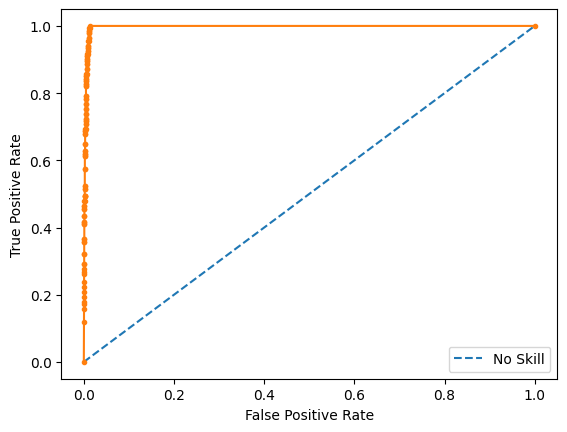

In [44]:
loaded_model = pickle.load(open('../models/at1_week4_model/model_lda_for_validation.sav', 'rb'))
plot_roc(X_val, y_val, loaded_model)